# Assignment 3

Turn in the assignment via the autograder:
`python3 -m autograder.run.submit Assignment3.ipynb` from the Assignment3 directory.

Before you turn this problem in, make sure everything runs as expected. To do so, restart the kernel and run all cells (in the menubar, select Runtime→→Restart and run all).
#### Show your work!
Whenever you are asked to find the solution to a problem, be sure to also **show how you arrived** at your answer.

### Resources

[1] https://community.plotly.com/t/two-3d-surface-with-different-color-map/18931/2 (Different color plots plotly)

[2] https://plotly.com/python/3d-surface-plots/ [plotting surfaces]

[3] https://community.plotly.com/t/3d-scatter-plot-with-surface-plot/27556/5 [plotting scatter plots]

[4] https://community.plotly.com/t/what-colorscales-are-available-in-plotly-and-which-are-the-default/2079 [color scales]

## Problem 1: Local Search on the Ackley Surface
---

As discussed in class with Local Search problems the path to the goal is not as important as the goal itself. In this question we work with the Ackley function, a non-convex function typically used as a test for optimization algorithms.

The Achkey function has many local optima but only one global optimum that is $f(0,0) = 0$. Interestingly enough it might not be that easy to find this solution.

The Ackley function is defined as:

$$f(x,y):= -20exp[-0.2\sqrt{0.5(x^2 + y^2)}] -exp[0.5(cos(2\pi x) + cos(2\pi y))] + e + 20$$

The figure below illustrates the result of running three optimization methods on the Ackley Function. These solutions were found using methods A, B and C.


![](https://drive.google.com/uc?id=1K0_iokZu-TgjD0xrfGmWQbb-r67kINI0)



In this question, you will implement 3 optimization algorithms: 

1.   Stochastic Hill Climbing with Restarts (SHCR)
2.   Simulated Annealing (SA)
3.   Local Beam Search (LBS)

**Deliverables**

1. Complete this Notebook with implementation of SHCR, SA and LBS.
2. For each algorithm **visualize** the candidate solutions found at each
step using the provided ```create_ackley_figure()``` function. please see the image above an example of an image that should be included in your submission.



In [3]:
import numpy as np
from numpy import arange
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from numpy import meshgrid
from numpy import random
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed
from numpy.random import uniform
# hill climbing search of the ackley objective function
from numpy import asarray
import plotly.graph_objects as go

# objective function
def f(x, y):
	return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20

def create_ackley_figure(solution_points=np.array([]), soln_names=['A','B,','C']):
  """
  :param solution_points A numpy array of dimensions [i, n, 2]
  where i is the number of solution points you want to plot and n is the 
  number of steps used in estimating your solution. In each case use the same 
  number of steps if you want to plot all solutions on the same figure.

  :return An interactive Ackley function figure with/without solution points.
  """
  # define range for input
  r_min, r_max = -5.0, 5.0
  # sample input range uniformly at 0.1 increments
  xaxis = arange(r_min, r_max, 0.1) # (100,)
  yaxis = arange(r_min, r_max, 0.1) # (100,)
  # create a mesh from the axis
  x, y = meshgrid(xaxis, yaxis)

  # compute targets
  results = f(x, y)

  figure = go.Figure(data=[go.Surface(z=results, x=x, y=y,colorscale='Blues',showscale=False)])
  figure.update_layout(title='Ackley Function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

  if solution_points.size:
    soln_colors = ['Rainbow', 'Reds', 'Viridis']
    for i in range(len(solution_points)):
      x_sln = solution_points[i][:,0]
      y_sln = solution_points[i][:,1]
      zdata = f(x_sln, y_sln)
      figure.add_scatter3d(name=soln_names[i], x=x_sln, y=y_sln, z=zdata, mode='markers',
      marker=dict(size=1, color=[i / len(x_sln) for i in range(len(x_sln))], colorscale=soln_colors[i]))
      
      figure.update_layout(showlegend=True)
      
  return figure

In [ ]:
### RUN THIS ###
"""
This is the Ackley Function.
"""
ack_figure = create_ackley_figure()
ack_figure

### General Function Definitions

In [5]:
# objective function
def objective(v):
  """
  This function defines the Ackley surface, it has a minimum of 0. This 
  can be used to test if we have found points that yield the minimum value.
  :param v, a tuple representing a 2D point being tested.

  returns a value in the range [-5.0, 5.0]
  """
  x, y = v
  return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20

  
# check if a point is within the bounds of the search
def in_bounds(point, bounds=asarray([[-5.0, 5.0], [-5.0, 5.0]])):
  """
  It is possible our optimzation method could move us outside of our search 
  space, so it is helpful to check.
  :param point a tuple representing a 2D point
  :param a 2D array, that describes the bounds of each dimension of our point.
  returns a Boolean of whether the point lies in the bounds or not.
  """
	# enumerate all dimensions of the point
  for d in range(len(bounds)):
    # check if out of bounds for this dimension
    if point[d] < bounds[d, 0] or point[d] > bounds[d, 1]:
      return False
  return True

In [2]:
# Code for generating starting points
def generate_starting_points(bounds):
    start_position = rand(2)
    start_position[0] = start_position[0] * (bounds[0][-1] - bounds[0][0]) + bounds[0][0]
    start_position[1] = start_position[1] * (bounds[1][-1] - bounds[1][0]) + bounds[1][0]
    return start_position

# Code for generating stochastic neighbors
def generate_stochastic_neighbor(current_point, bounds, step_size):
    return current_point + random.uniform(low = -1, high = 1, size = len(bounds)) * step_size

### Part 1) Stochastic Hill Climbing with Restarts

1.   Implement SHCR in the cell below.
2.   Visualize and comment on the candidate points visited.


In [ ]:
# stochastic hill climbing with restarts algorithm
def stochastic_hillclimbing(objective, bounds, n_iterations, step_size, start_pt):
  """
  :param objective, the function we are trying to optimize
  :param bounds, the boundaries of the problem
  :param n_iterations number of times to repeat stochastic hill climbing
  :param step_size how much we should move
  :param start_pt the point we start optimizing from.
  returns [solution, solution_value, candidates]
  """
  ### YOUR CODE HERE ###
  return

def random_restarts(objective, bounds, n_iter, step_size, n_restarts):
  """
  :param objective, the function we are trying to optimize
  :param bounds, the boundaries of the problem
  :param n_iter number of times to repeat stochastic hill climbing 
  :param step_size how much we should move
  :param n_restarts, the number of times we restart.
  returns [best solution, best solution value, visited points]
  """
  ### YOUR CODE HERE ###
  return -1, -1, -1


# TEST CASE:

# seed the pseudorandom number generator
seed(240)
# define range for input
bounds = asarray([[-5.0, 5.0], [-5.0, 5.0]])
# define the total iterations
n_iter = 100
# define the maximum step size
step_size = 0.05
# total number of random restarts
n_restarts = 300
# perform the hill climbing search
best, score, shcr_candidates = random_restarts(objective, bounds, n_iter, step_size, n_restarts)
print('Done!')
print('f(%s) = %f' % (best, score))

In [ ]:
# Helpful analysis
# An example of plotting solutions from 3 optimziation methods.
# all_method_candidates has shape [3, 1000, 2], the first dim is the number of solutions
# the second dim is the number of steps taken in each method.
shcr_candidates = np.random.rand(100,2) # EXAMPLE PURPOSES ONLY replace with your actual solution.
shcr_candidates = shcr_candidates.reshape(-1,2)
all_method_candidates = np.array([shcr_candidates])
ack_figure = create_ackley_figure(all_method_candidates)
ack_figure

### Optional Analysis - Stochastic Hill Climbing


In [57]:
# OPTIONAL: Analysis to graph your answers; comment out once stochastic_hillclimbing is implemented

# all_method_candidates = np.array([shcr_candidates])
# ack_figure = create_ackley_figure(all_method_candidates)
# ack_figure.show()


The figure depicts each search path for the given random restarts done for the stochastic hill algorithm. Eventually, after a certain number of restarts, we choose an initial point close enought to the optimum at f(0,0) so that SHC was able to find the point. This demonstrates how SHC with restarts is asymtotically complete, as it will evenutally reach the global minimum after a asymptotic number of random restarts.

### Part 2) Simulated Annealing

1.   Implement SA in the cell below.
2.   Visualize and comment on the candidate points visited.

In [ ]:
def get_temperature_schedule(epoch, temp, cos_frequency, diff):
  """
  :param epoch Iterations elapsed
  :param temp Temperature
  :param cos_frequency Cosine annealing cycle frequency
  :param diff Difference between value of candidate solution and current solution.
  """
  # calculate temperature for current epoch (1.001 to prevent t from going to zero)
  t = temp * (1.001 + np.cos(epoch*(2*np.pi*cos_frequency)))/2
  # calculate acceptance criterion
  criterion = exp(-diff / t)
  return criterion

# simulated annealing algorithm
def simulated_annealing(objective, bounds, n_iterations, step_size, temp, cos_frequency):
  """
  :param objective, the function we are trying to optimize
  :param bounds, the boundaries of the problem
  :param n_iterations number of times to repeat stochastic hill climbing
  :param step_size how much we should move
  :param temp temperature for each epoch
  :param cos_frequency Cosine annealing cycle frequency
  returns [solution, solution_value, candidates]
  """
  ### YOUR CODE HERE ###
  return -1, -1, -1

# seed the pseudorandom number generator
seed(240)
# define range for input
bounds = asarray([[-5.0, 5.0], [-5.0, 5.0]])
# define the total iterations
n_iterations = 10000
# define the maximum step size
step_size = 0.1
# initial temperature
temp = 5
# cosine annealing cycle frequency
cos_frequency = .01
# perform the simulated annealing search
best, score, sa_candidates = simulated_annealing(objective, bounds, n_iterations, step_size, temp, cos_frequency)
print('Done!')
print('f(%s) = %f' % (best, score))

### Optional Analysis - Simulated annealing

In [7]:
# OPTIONAL: Analysis to graph your answers; comment out once simulated_annealing is implemented

# print(sa_candidates)
# all_method_candidates = np.array([sa_candidates])
# ack_figure = create_ackley_figure(all_method_candidates)
# ack_figure.show()

### Part 3) Local Beam Search



1.   Implement LBS in the cell below.
2.   Visualize and comment on the candidate points visited.
3.   Compare all 3 implementations by commenting on the distribution of points on the Ackley surface and the empirical run time of each method.


In [60]:
# generates a cross shaped set of neighbors based on step size
def generate_neighbors(point, step_size=0.1):
    point = point.reshape(2,1)
    shifts = np.array([step_size*(2**i) for i in range(0,11)])
    neighbors = point + np.concatenate([
       np.array([np.zeros(len(shifts)),  shifts]),
       np.array([np.zeros(len(shifts)), -shifts]),
       np.array([ shifts, np.zeros(len(shifts))]),
       np.array([-shifts, np.zeros(len(shifts))]),
    ], axis=1)
    return neighbors

def local_beam_search(objective, bounds, step_size, k, n_iterations):
  """
  :param objective, the function we are trying to optimize
  :param bounds, the boundaries of the problem
  :param k, how many candidates to consider
  :param n_iterations, how long to search for.
  returns [solution, solution_value, candidates]
  """
  ### YOUR CODE HERE ###
  return -1, -1, -1

# seed the pseudorandom number generator
seed(240)
# define range for input
bounds = asarray([[-5.0, 5.0], [-5.0, 5.0]])
# define the total iterations
n_iterations = 1000
# define the maximum step size
step_size = 0.002
# candidates to consider
k = 3
sequences = local_beam_search(objective, bounds, step_size, k, n_iterations)


In [61]:
# OPTIONAL: Analysis to graph your answers; comment out once local_beam_search is implemented

# all_method_candidates = np.array([lbs_candidates])
# ack_figure = create_ackley_figure(all_method_candidates)
# ack_figure.show()

In [62]:
# Optional: Analysis of all Three Experiment Graphs

# min_size = len(sa_candidates) if len(shcr_candidates) < len(sa_candidates) else len(shcr_candidates)
# min_size = len(lbs_candidates) if len(lbs_candidates) < min_size else min_size

# all_method_candidates = np.array([shcr_candidates[0:min_size], sa_candidates[0:min_size], lbs_candidates[0:min_size]])
# ack_figure = create_ackley_figure(all_method_candidates)
# ack_figure.show()


## Problem 2: CSP
---

Consider the following constraint satisfaction problem. A linear graph has nodes of the following colors:

- Red
- Yellow
- Green
- Blue
- Violet

Each node has a domain of {1, 2, ..., 9}.

Each node type has the following constraints on its value:

- Red - No contraints
- Yellow - equals the rightmost digit of of the product of all its neighbors
- Green - equals the rightmost digit of the sum of all its neighbors 
- Blue - equals the leftmost digit of the sum of all its neighbors
- Violet - equals the leftmost digit of the product of all of its neighbors

As a reminder here is the pseudo code for the Min-Conflicts search algorithm:
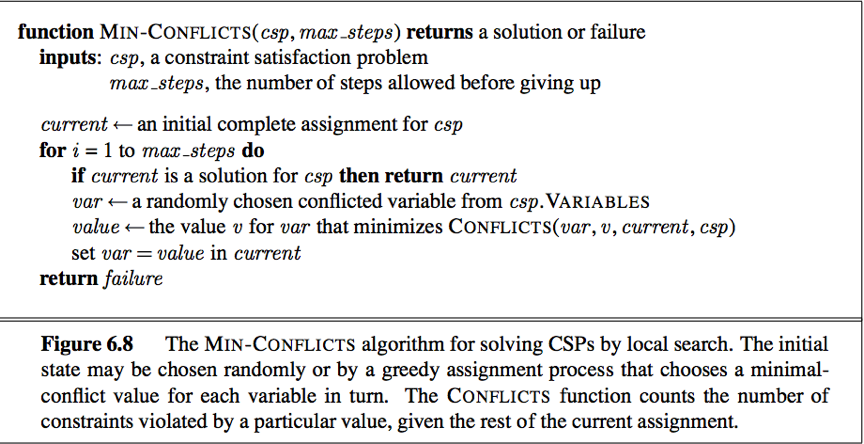

**Notes:**

- It's possible that you won't converge to a solution in a single run. Try a few runs to see if you get to a solution.
- The testcases are to show you what a problem looks like, we will test/grade your program on different examples.

### Part 1) Implementation
Complete the function ```solve_csp``` defined below. You may find some helper functions useful.

In [63]:
def solve_csp(nodes, arcs, max_steps):
    """
    This function solves the csp using the MinConflicts Search Algorithm.

    :param nodes, a list of letters that indicates what type of node it is,
                  the index of the node in the list indicates its id
                  letters = {R, Y, G, B, V}

    :param arcs,  a list of tuples that contains two numbers, indicating the
                  IDs of the nodes the arc connects.

    :param max_steps, max number of steps to make before giving up

    returns a list of values for the solution to the CSP where the
             index of the value corresponds the value for that given node.
    """
    node_values = []

    ### YOUR CODE HERE ###
    return node_values


### Part 2) Test Cases

Below we've included 4 test cases to help you debug your code. Your submitted code will be tested on other cases as well, but if your implementation of the above Min-Conflicts search algorithm is able to solve these problems, you should be good to go.

In [ ]:
# test Case 1

nodes = 'YGVRB'
arcs = [(0,1), (0,2), (1,2), (1,3), (1,4), (2,3), (2,4)]
max_steps = 1000

for _ in range(max_steps):
    sol = solve_csp(nodes, arcs, max_steps)
    if sol != []:
        print(nodes)
        break
        
all_solutions = [[1, 1, 1, 7, 2],[2, 1, 2, 4, 3],[2, 6, 7, 6, 1],[2, 8, 9, 6, 1],
                 [3, 3, 1, 5, 4],[6, 2, 8, 7, 1],[6, 7, 8, 2, 1],[6, 9, 4, 8, 1]]

if sol == []:
    print('No solution')
else:
    if sol in all_solutions:
        print('Solution found:', sol)
    else:
        print('ERROR: False solution found:', sol)

In [ ]:
# test Case 2

nodes = 'YVBGR'
arcs = [(0,1), (0,2), (1,3), (2,4)]
max_steps = 1000

for _ in range(max_steps):
    sol = solve_csp(nodes, arcs, max_steps)
    if sol != []:
        print(nodes)
        break
        
all_solutions = [[1, 1, 1, 1, 9], [1, 3, 7, 3, 6], [1, 7, 3, 7, 2], [1, 9, 9, 9, 8]]

if sol == []:
    print('No solution')
else:
    if sol in all_solutions:
        print('Solution found:', sol)
    else:
        print('ERROR: False solution found:', sol)

In [ ]:
# test Case 3

nodes = 'VYGBR'
arcs = [(0,1), (1,2), (2,3), (3,4)]
max_steps = 1000

for _ in range(max_steps):
    sol = solve_csp(nodes, arcs, max_steps)
    if sol != []:
        print(nodes)
        break
        
all_solutions = [[2, 2, 1, 9, 8],[3, 3, 1, 8, 7],[4, 4, 1, 7, 6],[5, 5, 1, 6, 5],[5, 5, 3, 8, 5],
                 [6, 6, 1, 5, 4],[7, 7, 1, 4, 3],[8, 8, 1, 3, 2],[8, 8, 6, 8, 2],[9, 9, 1, 2, 1]]

if sol == []:
    print('No solution')
else:
    if sol in all_solutions:
        print('Solution found:', sol)
    else:
        print('ERROR: False solution found:', sol)

In [ ]:
# test Case 4

nodes = 'YGVBR'
arcs = [(0,1), (0,2), (1,3), (2,3), (3,4), (1,2)]
max_steps = 1000

for _ in range(max_steps):
    sol = solve_csp(nodes, arcs, max_steps)
    if sol != []:
        print(nodes)
        break
        
all_solutions = [[4, 4, 1, 9, 4],[4, 7, 2, 1, 1],[4, 7, 2, 1, 2],[4, 7, 2, 1, 3],[4, 7, 2, 1, 4],
                 [4, 7, 2, 1, 5],[4, 7, 2, 1, 6],[4, 7, 2, 1, 7],[4, 7, 2, 1, 8],[4, 7, 2, 1, 9],
                 [4, 8, 3, 1, 1],[4, 8, 3, 1, 2],[4, 8, 3, 1, 3],[4, 8, 3, 1, 4],[4, 8, 3, 1, 5],
                 [4, 8, 3, 1, 6],[4, 8, 3, 1, 7],[4, 8, 3, 1, 8],[5, 1, 5, 1, 4],[5, 1, 5, 1, 5],
                 [5, 1, 5, 1, 6],[5, 1, 5, 1, 7],[5, 1, 5, 1, 8],[5, 1, 5, 1, 9]]

if sol == []:
    print('No solution')
else:
    if sol in all_solutions:
        print('Solution found:', sol)
    else:
        print('ERROR: False solution found:', sol)